### A) Importing Libraries

To build an e-commerce recommendation system based on product ID, user ID, and ratings, you can use collaborative filtering techniques. Here's a brief overview of the process:

Data Preparation: Create a user-item interaction matrix with user IDs as rows, product IDs as columns, and ratings as values.

Matrix Factorization: Apply techniques like Singular Value Decomposition (SVD) to decompose the matrix into lower-dimensional matrices representing user and product features.

Predict Ratings: Use the decomposed matrices to predict missing ratings for product-user pairs.

Generate Recommendations: Recommend products to users based on the predicted ratings for items they haven't interacted with.

In [3]:
from scipy.sparse.linalg import svds 
# Efficiently performs Singular Value Decomposition (SVD) on sparse matrices, useful for dimensionality reduction in large-scale data.

import warnings
warnings.filterwarnings('ignore') # Suppresses all warnings to prevent them from cluttering the output.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity 
# Computes cosine similarity between samples in a matrix, useful for measuring similarity in text analysis and recommendation systems.

from sklearn.metrics import mean_squared_error


### B) Loading Dataset

In [4]:
df = pd.read_csv(r"C:\Users\BS . AMIRTHA\Downloads\ratings_Electronics.csv")

In [5]:
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


We observe that this dataset does not have a header, so we need to specify header=None when loading the data.

In [6]:
df = pd.read_csv(r"C:\Users\BS . AMIRTHA\Downloads\ratings_Electronics.csv", header = None )

In [7]:
df.head() #resolved

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


Next, we will add column names to the dataset to facilitate easier understanding and data analysis.

In [8]:
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

In [9]:
df.head() #solved

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


Dropping timestamps helps focus on product similarity and simplifies the model by eliminating unnecessary complexity related to time-related trends.

In [10]:
df = df.drop('timestamp', axis=1) #Dropping timestamp

In [11]:
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### C) Missing value analysis

In [12]:

# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

### D) Exploratory Data Analysis

In [13]:
#shape 
df.shape

(7824482, 3)

In [14]:
#datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [15]:
df.describe()

,rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [16]:

# Summary statistics of 'rating' variable
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

1)Positive Skew: The median rating being higher than the mean and the high concentration of ratings at the maximum value suggest that most users rate products highly, with a concentration of top ratings (5).

2)Low Variability: With the mean close to the maximum rating and a relatively high median, the data shows a positive bias towards higher ratings.

3)Distribution: The 25th percentile being much lower than the 75th percentile indicates that while most ratings are high, there is a significant number of lower ratings.tings.


In this dataset, the mean rating is 4.012337, while the median (50th percentile) is 5.0. Typically, if the mean is less than the median, it indicates a left-skewed (negative skew) distribution. However, given the context of ratings, where the maximum is 5 and the median is at the upper limit, it suggests that most ratings are clustered at the high end, causing the mean to be lower than the median. This can occur in rating systems where users tend to give high ratings frequently, but some lower ratings bring down the average.

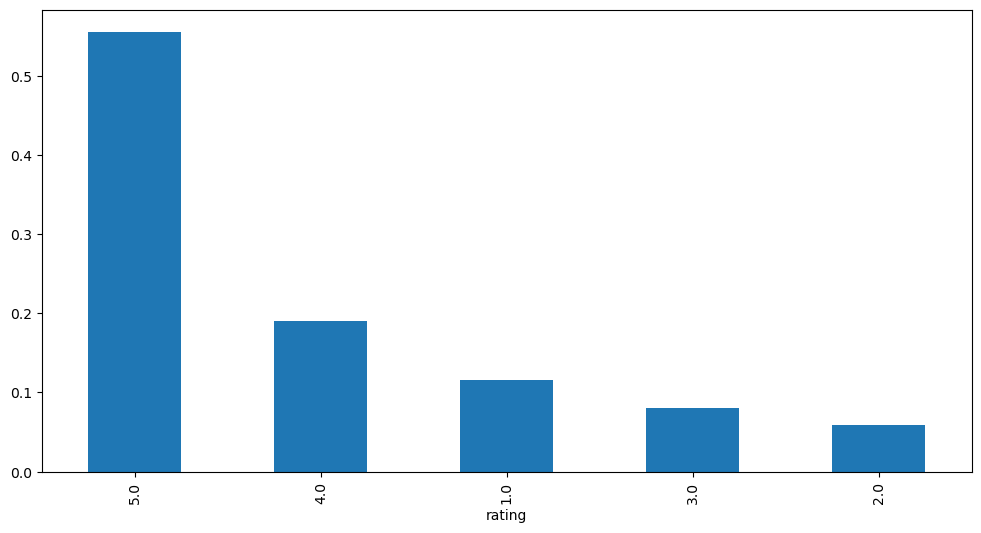

In [17]:
#To understand the rating distribution

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is right-skewed, with over 50% of ratings being 5 stars. Ratings of 4 stars account for just under 20%, while ratings decrease progressively, with fewer than 10% of ratings being 2 stars.

In [18]:
# Number of unique user id and product id in the data
print('Number of unique USERS = ', df['user_id'].nunique())
print('Number of unique ITEMS  = ', df['prod_id'].nunique())

Number of unique USERS =  4201696
Number of unique ITEMS  =  476002


Out of 7,824,482 ratings, there are 4,201,696 unique users and 476,002 unique items. This high number of unique users and items highlights the scale and diversity of the dataset, which is crucial for building effective and personalized recommendation systems..2

In [19]:
# Top 10 users based on the number of ratings
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
print("Top 10 users by number of ratings:")
print(most_rated)


Top 10 users by number of ratings:
user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64


Identifying the top 10 users based on the number of ratings helps to understand which users are most active. This insight is valuable for capturing influential feedback and ensuring the quality of recommendations by focusing on frequent raters.

We are selecting a subset of the dataset with users who have given 50 or more ratings to ensure a robust sample of active users. This helps improve the quality and reliability of data processing by focusing on users with sufficient interaction history.

In [20]:
counts = df['user_id'].value_counts()
print("The number of Unique User Id in the final data =",len(counts))

The number of Unique User Id in the final data = 4201696


In [21]:
df_final = df[df['user_id'].isin(counts[counts >= 50].index)] #users who have give 50 or more ratings

In [22]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  48190


Here, we have selected a sample with the specified number of observations for analysis and we will use "df_final" to build recommendation systems

### E) Density of the rating matrix

Checking the density of the rating matrix helps determine the proportion of observed ratings relative to the total possible ratings. This aids in choosing the appropriate recommendation algorithms, optimizing performance, and deciding on data imputation strategies. Understanding matrix density is essential for efficient memory and computational resource management.A low density indicates a sparse matrix, requiring specialized handling, while a higher density suggests more complete data.








In [23]:

#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (1540, 48190)


Above shape of the final ratings matrix represents 1540 unique users and 48190 unique products

In [24]:
#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

given_num_of_ratings =  125871


### Purpose:
Finding the number of non-zero entries in the interaction matrix helps us understand the number of actual ratings (interactions) between users and products. This provides insight into the matrix's sparsity, which is crucial for selecting and applying the right recommendation algorithms.

### Understanding from the Output:
- **Non-zero Entries**: Indicates the total number of ratings given by users. More non-zero entries suggest higher user engagement and a denser matrix.
- **Sparsity**: A low number of non-zero entries compared to the total possible entries (user count * product count) indicates a sparse matrix, requiring specialized techniques for efficient processing and accurate recommendations.

In [25]:
#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

possible_num_of_ratings =  74212600


### Purpose:
Calculating the possible number of ratings helps us understand the maximum potential interactions between users and products in the dataset. This value is essential for assessing the sparsity of the interaction matrix by comparing it to the actual number of ratings.

### Understanding from the Output:

**Possible Ratings:** This is the product of the number of unique users and unique products, representing the total number of possible user-product interactions.
**Sparsity Assessment:** By comparing the possible number of ratings with the actual number of ratings, we can determine the sparsity of the matrix. A high ratio of possible to actual ratings indicates a sparse matrix, while a low ratio indicates a denser matrix.

In [26]:
#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()
     

density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Given Density: The 0.17% density indicates very low user-product interaction.Given the high sparsity, we should consider using recommendation techniques designed for sparse data. Therefore we use **Rank-Based Recommendation Systems** are straightforward and work well with sparse data but lack personalization.**Collaborative Filtering-Based Recommendation Systems** offer personalized recommendations but can face challenges with sparse data, which can be mitigated through techniques like matrix factorization or hybrid approaches.

## F)Rank Based Recommendation System

This helps us to understand which products have the highest average ratings and how many ratings each product has received.
This can be useful for understanding product quality and popularity, and for making data-driven decisions about which products to promote or focus on.

In [27]:
print(df_final.dtypes)

user_id     object
prod_id     object
rating     float64
dtype: object


Since prod_id and user_id are alphanumeric, keep them as object or categorical types. 

In [57]:
# Convert 'rating' to numeric (ensure ratings are valid numbers)
df_final['rating'] = pd.to_numeric(df_final['rating'], errors='coerce')

# Drop rows with missing 'rating' after conversion
df_final = df_final.dropna(subset=['rating'])

# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a DataFrame with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sort the DataFrame by average of ratings
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

# Display the top results
print(final_rating.head())


            avg_rating  rating_count
prod_id                             
0594451647         5.0             1
B003RRY9RS         5.0             1
B003RR95Q8         5.0             1
B003RIPMZU         5.0             1
B003RFRNYQ         5.0             2


The output shows the average rating for each product, with prod_id values listed alongside their average ratings and count of ratings. For instance, B003RFRNYQ has an average rating of 5.0 based on 2 ratings, indicating a highly rated product with limited feedback.

In [29]:

#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    
    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values('avg_rating',ascending=False)
    
    return recommendations.index[:n]

This approach ensures that the recommended products not only have high ratings but also a significant number of ratings to ensure reliability.In recommendation systems, focusing on minimum interactions rather than maximum interactions is crucial for a few reasons:

Reliability of Ratings: Products with very few interactions might have high ratings, but those ratings could be less reliable due to the small sample size. By setting a minimum threshold, you ensure that only products with a sufficient number of ratings are considered, improving the reliability of the average rating.

Avoiding Bias from Outliers: Products with only a few ratings might be subject to outlier ratings that can skew the average. Ensuring a minimum number of interactions helps mitigate the impact of such outliers, leading to more consistent and meaningful recommendations.

Overall, using a minimum interaction threshold helps balance the quality and quantity of the data, leading to more robust and trustworthy recommendations.

### Recommending top 5 products with 50 minimum interactions based on popularity

In [30]:

list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### Recommending top 5 products with 100 minimum interactions based on popularity

In [31]:

list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

### G) User based collaborative filtering

In [32]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Currently, the `user_id` is stored as an object data type. To standardize it, we'll replace `user_id` with integer values ranging from 0 to 1539, converting the index to an integer type while maintaining a unique representation for each user.

In [58]:

final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To identify similar users and calculate their similarity scores








In [34]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = [] #Initialize Similarity List
    for user in range(0, interactions_matrix.shape[0]): #  Loop Through Each User
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        # Store Similarity Scores
        similarity.append((user,sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True) #Sort Users by Similarity
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user_index) 
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score
     

Finding out top 10 similar users to the user index 3 and their similarity score

In [35]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[320, 12, 793, 261, 156, 1493, 1250, 567, 753, 1360]

In [36]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

Finding out top 10 similar users to the user index 1500 and their similarity score

In [37]:

similar = similar_users(1500, final_ratings_matrix)[0][0:10]
similar

[630, 417, 579, 1520, 1228, 1016, 587, 883, 1067, 1284]

In [38]:
#Print the similarity score
similar_users(1521,final_ratings_matrix)[1][0:10]
     

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

Function to recommend products

In [39]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

The recommendations function:

1.Finds users similar to the target user.

2.Identifies items the target user has not interacted with but similar users have.

3.Generates a list of product recommendations based on these interactions.

Recommend 5 products to user index 3 based on similarity based collaborative filtering


In [40]:
recommendations(3,5,final_ratings_matrix)

['B001GCQ3KM', 'B001OQABXK', 'B00114LG7U', 'B005FAPYXS', 'B000CRFOMK']

In [41]:
recommendations(1500,5,final_ratings_matrix)

['B006QB1RPY', 'B0000AI0N1', 'B00E3W15P0', 'B001QUA6RA', 'B0019MAVIE']

### H)Singular Value Decomposition (SVD)

**Model-Based Collaborative Filtering: Singular Value Decomposition (SVD)**

SVD is a powerful technique for handling sparse interaction matrices, such as those found in recommendation systems. Given the high sparsity of our interaction matrix, SVD helps by decomposing it into matrices with lower dimensions, which capture the underlying patterns in user-item interactions.

- **Sparsity Handling:** SVD is well-suited for large, sparse matrices because it efficiently reduces dimensionality while retaining important features. Using the `sparse.linalg.svds()` function is ideal for this task.

- **Latent Features:** By choosing \( k = 50 \) latent features, we create a reduced representation of users and items, which helps in predicting missing ratings and enhancing the recommendation accuracy.

A CSR (Compressed Sparse Row) matrix efficiently stores large, sparse matrices by only saving non-zero elements, their column indices, and row pointers. This format is ideal for memory efficiency and fast matrix operations in recommendation systems and other data-intensive applications.)

In [42]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)

Single Value Decomposition

In [43]:

# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)
     

In [44]:
U.shape

(1540, 50)

This indicates that each user is characterized by a 50-dimensional vector of latent features, used to capture underlying patterns in their preferences.

**1540 Rows:** Each row represents a user in the interaction matrix.

**50 Columns:** Each column represents one of the 50 latent features derived from the Singular Value Decomposition (SVD).

In [45]:
sigma.shape

(50, 50)

50 Rows and 50 Columns: This is a diagonal matrix containing the singular values from the Singular Value Decomposition (SVD).

In [46]:
Vt.shape

(50, 48190)

Vt contains the feature vectors for each of the 1465 products, projected into the 50 latent feature space.

Let's reconstruct the original matrix using the `U`, `Sigma`, and `Vt` matrices. This will produce the predicted ratings for all users and products.

 Predicting ratings

In [47]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)
     

In [48]:
#Function to recommend products

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))



Summary
**Retrieve the user's** ratings and predictions.
**Create a DataFrame** to compare actual ratings with predictions.
**Filter out products** the user has already rated.
**Sort by predicted ratings** and recommend the top products.
This function helps users discover new products they might like based on predictions from the recommendation system.

In [49]:
## Recommending top 5 products to user id 132

#Enter 'user index' and 'num_recommendations' for the user
recommend_items(132,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 132):

Recommended Products
24827    0.454033
33113    0.418512
15538    0.369557
18891    0.352582
38250    0.322423
Name: user_predictions, dtype: float64


In [50]:
## Recommending top 10 products to user id 140

recommend_items(140,final_ratings_sparse,preds_matrix,10)



Below are the recommended products for user(user_id = 140):

Recommended Products
22169    1.928075
39003    1.793747
31001    1.764419
16159    1.612766
29340    1.592542
42587    1.578196
21117    1.536016
43598    1.480171
38993    1.460975
25554    1.422903
Name: user_predictions, dtype: float64


### I) Evaluating the model

In [51]:

final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

prod_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [53]:

preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,0.061477,0.001214,0.123433,0.028490,0.016109,0.002855,0.174568,0.011367,0.012997
1,0.002286,0.010898,0.000724,0.130259,0.007506,0.003350,0.063711,0.000674,0.016111,0.002433,...,0.000038,0.013766,0.001473,0.025588,0.042103,0.004251,0.002177,0.024362,0.014765,0.038570
2,0.001655,0.002675,0.007355,0.007264,0.005152,0.003986,0.003480,0.006961,0.006606,0.002719,...,0.001708,0.051040,0.000325,0.054867,0.017870,0.004996,0.002426,0.083928,0.112205,0.005964
3,0.001856,0.011019,0.005910,0.014134,0.000179,0.001877,0.005391,0.001709,0.004968,0.001402,...,0.000582,0.009326,0.000465,0.048315,0.023302,0.006790,0.003380,0.005460,0.015263,0.025996
4,0.001115,0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,0.019347,0.012749,0.001026,0.001364,0.020580,0.011828,0.012770


In [54]:
avg_preds=preds_df.mean()
avg_preds.head()

prod_id
0594451647    0.003360
0594481813    0.005729
0970407998    0.008566
0972683275    0.035330
1400501466    0.006966
dtype: float64

In [55]:

rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
0594451647,0.003247,0.003360
0594481813,0.001948,0.005729
0970407998,0.003247,0.008566
0972683275,0.012338,0.035330
1400501466,0.012987,0.006966


Given the average predicted ratings generally exceed the average actual ratings, it suggests that while the model is performing well overall, it may be consistently overestimating the ratings. 

In [56]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.013679389779858015 






### RMSE for Recommendation Systems

- **RMSE < 1.0**: Excellent performance; predictions are very close to actual ratings.
- **1.0 - 2.0**: Good performance; predictions are reasonably accurate but can be improved.
- **RMSE > 2.0**: Needs improvement; predictions are significantly off from actual ratings.

Lower RMSE values indicate better model accuracy. The acceptable range depends on the context and scale of the ra

An RMSE (Root Mean Squared Error) of 0.0137 for the SVD model indicates the average error between the predicted and actual ratings is quite low. This suggests that the model's predictions are fairly close to the true ratings, reflecting good performance in accurately estimating user preferences.tings.